In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml
from sklearn import datasets

In [6]:
iris = datasets.load_iris()
X = iris.data  
y = iris.target


In [7]:
X = StandardScaler().fit_transform(X)


In [8]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(50, 4)
(50, 4)


In [9]:
indices=np.arange(25)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:25]
x_train=np.concatenate((np.array(x_neg[0:25])[indices],x_pos)).reshape(-1,4)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [10]:
x_test = x_neg[25:50].reshape(-1,4)
y_test = y_neg[25:50].reshape(-1,1)

 # Standard Bloom Filter

In [11]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [12]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [13]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [14]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [15]:
num_of_iterations = 5#Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(50, 4)
Size: 10 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000602 - Time Taken to create Projecion: 0.069621 



Size: 20 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000365 - Time Taken to create Projecion: 0.034374 



Size: 30 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000405 - Time Taken to create Projecion: 0.037457 



Size: 40 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000572 - Time Taken to create Projecion: 0.036150 



Size: 50 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000341 - Time Taken to create Projecion: 0.060021 



Size: 60 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002386 - Time Taken to create Projecion: 0.050987 



Size: 70 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000412 - Time Taken to create Projecion: 0.041987 



Size: 80 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000406 - Time Taken to create Projecion: 0.049296 



Size: 90

Size: 700 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001608 - Time Taken to create Projecion: 0.096170 



Size: 710 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001663 - Time Taken to create Projecion: 0.113863 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001334 - Time Taken to create Projecion: 0.076218 



Size: 730 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002057 - Time Taken to create Projecion: 0.099652 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002030 - Time Taken to create Projecion: 0.095503 



Size: 750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001596 - Time Taken to create Projecion: 0.071003 



Size: 760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001999 - Time Taken to create Projecion: 0.093260 



Size: 770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001579 - Time Taken to create Projecion: 0.082096 



Size: 780 Bits - FPR: 0.000000 - Time Ta

Size: 1390 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003348 - Time Taken to create Projecion: 0.108251 



Size: 1400 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002273 - Time Taken to create Projecion: 0.123986 



Size: 1410 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003903 - Time Taken to create Projecion: 0.152013 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002267 - Time Taken to create Projecion: 0.122761 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002196 - Time Taken to create Projecion: 0.119298 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004123 - Time Taken to create Projecion: 0.118243 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003151 - Time Taken to create Projecion: 0.120344 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002313 - Time Taken to create Projecion: 0.130182 



Size: 1470 Bits - FPR: 0.000000 

Size: 2070 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003191 - Time Taken to create Projecion: 0.168083 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003243 - Time Taken to create Projecion: 0.181002 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003443 - Time Taken to create Projecion: 0.161645 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003851 - Time Taken to create Projecion: 0.154943 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004556 - Time Taken to create Projecion: 0.271376 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004179 - Time Taken to create Projecion: 0.390212 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.011665 - Time Taken to create Projecion: 0.313269 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005011 - Time Taken to create Projecion: 0.530552 



Size: 2150 Bits - FPR: 0.000000 

Size: 2750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006342 - Time Taken to create Projecion: 0.346484 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005150 - Time Taken to create Projecion: 0.246760 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.007004 - Time Taken to create Projecion: 0.292625 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.007385 - Time Taken to create Projecion: 0.234295 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003777 - Time Taken to create Projecion: 0.216885 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004518 - Time Taken to create Projecion: 0.218562 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003366 - Time Taken to create Projecion: 0.242269 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004176 - Time Taken to create Projecion: 0.216619 



Size: 2830 Bits - FPR: 0.000000 

Size: 430 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.001065 - Time Taken to create Projecion: 0.183769 



Size: 440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001165 - Time Taken to create Projecion: 0.148227 



Size: 450 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003348 - Time Taken to create Projecion: 0.104405 



Size: 460 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.003922 - Time Taken to create Projecion: 0.231405 



Size: 470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001533 - Time Taken to create Projecion: 0.160282 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002371 - Time Taken to create Projecion: 0.107492 



Size: 490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001000 - Time Taken to create Projecion: 0.090670 



Size: 500 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000621 - Time Taken to create Projecion: 0.059512 



Size: 510 Bits - FPR: 0.040000 - Time Ta

Size: 1120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001795 - Time Taken to create Projecion: 0.168220 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002243 - Time Taken to create Projecion: 0.102185 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002005 - Time Taken to create Projecion: 0.107204 



Size: 1150 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002293 - Time Taken to create Projecion: 0.138414 



Size: 1160 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001947 - Time Taken to create Projecion: 0.266010 



Size: 1170 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004139 - Time Taken to create Projecion: 0.582697 



Size: 1180 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002030 - Time Taken to create Projecion: 0.447056 



Size: 1190 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004509 - Time Taken to create Projecion: 0.257731 



Size: 1200 Bits - FPR: 0.000000 

Size: 1810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003707 - Time Taken to create Projecion: 0.608657 



Size: 1820 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005291 - Time Taken to create Projecion: 0.337001 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004710 - Time Taken to create Projecion: 0.338798 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.015322 - Time Taken to create Projecion: 0.314151 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.011055 - Time Taken to create Projecion: 0.514188 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004403 - Time Taken to create Projecion: 0.248950 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003980 - Time Taken to create Projecion: 0.318670 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.010812 - Time Taken to create Projecion: 0.224229 



Size: 1890 Bits - FPR: 0.000000 

Size: 2490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.010136 - Time Taken to create Projecion: 0.344762 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006876 - Time Taken to create Projecion: 0.322407 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004131 - Time Taken to create Projecion: 0.321759 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006490 - Time Taken to create Projecion: 0.273678 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005991 - Time Taken to create Projecion: 0.309322 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006919 - Time Taken to create Projecion: 0.263301 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005228 - Time Taken to create Projecion: 0.342308 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005450 - Time Taken to create Projecion: 0.226446 



Size: 2570 Bits - FPR: 0.000000 

Size: 170 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000563 - Time Taken to create Projecion: 0.055721 



Size: 180 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000576 - Time Taken to create Projecion: 0.070112 



Size: 190 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000498 - Time Taken to create Projecion: 0.080384 



Size: 200 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000881 - Time Taken to create Projecion: 0.085599 



Size: 210 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000670 - Time Taken to create Projecion: 0.052183 



Size: 220 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000833 - Time Taken to create Projecion: 0.055151 



Size: 230 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.000386 - Time Taken to create Projecion: 0.044468 



Size: 240 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000620 - Time Taken to create Projecion: 0.061371 



Size: 250 Bits - FPR: 0.000000 - Time Ta

Size: 870 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002082 - Time Taken to create Projecion: 0.101952 



Size: 880 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002065 - Time Taken to create Projecion: 0.151973 



Size: 890 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002168 - Time Taken to create Projecion: 0.117425 



Size: 900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002359 - Time Taken to create Projecion: 0.089706 



Size: 910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002425 - Time Taken to create Projecion: 0.107647 



Size: 920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002337 - Time Taken to create Projecion: 0.135073 



Size: 930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002527 - Time Taken to create Projecion: 0.104191 



Size: 940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002623 - Time Taken to create Projecion: 0.124928 



Size: 950 Bits - FPR: 0.000000 - Time Ta

Size: 1550 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002376 - Time Taken to create Projecion: 0.277154 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005336 - Time Taken to create Projecion: 0.207424 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.010930 - Time Taken to create Projecion: 0.424724 



Size: 1580 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002193 - Time Taken to create Projecion: 0.119721 



Size: 1590 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003673 - Time Taken to create Projecion: 0.139614 



Size: 1600 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003792 - Time Taken to create Projecion: 0.270442 



Size: 1610 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.011744 - Time Taken to create Projecion: 0.163094 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002099 - Time Taken to create Projecion: 0.164917 



Size: 1630 Bits - FPR: 0.000000 

Size: 2230 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004417 - Time Taken to create Projecion: 0.264705 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004149 - Time Taken to create Projecion: 0.536533 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003782 - Time Taken to create Projecion: 0.746419 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.009564 - Time Taken to create Projecion: 0.537162 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.031584 - Time Taken to create Projecion: 0.558034 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003808 - Time Taken to create Projecion: 1.289136 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.015408 - Time Taken to create Projecion: 1.110620 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.028854 - Time Taken to create Projecion: 0.607524 



Size: 2310 Bits - FPR: 0.000000 

Size: 2910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006917 - Time Taken to create Projecion: 0.316202 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.008476 - Time Taken to create Projecion: 0.245145 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005929 - Time Taken to create Projecion: 0.309039 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006349 - Time Taken to create Projecion: 0.301162 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005231 - Time Taken to create Projecion: 0.284956 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006047 - Time Taken to create Projecion: 0.313771 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006955 - Time Taken to create Projecion: 0.340542 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005884 - Time Taken to create Projecion: 0.313501 



Size: 2990 Bits - FPR: 0.000000 

Size: 590 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001375 - Time Taken to create Projecion: 0.091716 



Size: 600 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001504 - Time Taken to create Projecion: 0.076121 



Size: 610 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001437 - Time Taken to create Projecion: 0.077340 



Size: 620 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001606 - Time Taken to create Projecion: 0.074124 



Size: 630 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001310 - Time Taken to create Projecion: 0.082736 



Size: 640 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000840 - Time Taken to create Projecion: 0.075102 



Size: 650 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000858 - Time Taken to create Projecion: 0.083969 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001813 - Time Taken to create Projecion: 0.075909 



Size: 670 Bits - FPR: 0.000000 - Time Ta

Size: 1280 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002442 - Time Taken to create Projecion: 0.167821 



Size: 1290 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003484 - Time Taken to create Projecion: 0.116443 



Size: 1300 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002886 - Time Taken to create Projecion: 0.140226 



Size: 1310 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003628 - Time Taken to create Projecion: 0.171793 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002628 - Time Taken to create Projecion: 0.145085 



Size: 1330 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003310 - Time Taken to create Projecion: 0.149368 



Size: 1340 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001552 - Time Taken to create Projecion: 0.194713 



Size: 1350 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004870 - Time Taken to create Projecion: 0.439599 



Size: 1360 Bits - FPR: 0.000000 

Size: 1960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004344 - Time Taken to create Projecion: 0.274205 



Size: 1970 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004358 - Time Taken to create Projecion: 0.156259 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003947 - Time Taken to create Projecion: 0.175029 



Size: 1990 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003297 - Time Taken to create Projecion: 0.164270 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004979 - Time Taken to create Projecion: 0.164399 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005049 - Time Taken to create Projecion: 0.197530 



Size: 2020 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003948 - Time Taken to create Projecion: 0.173761 



Size: 2030 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005228 - Time Taken to create Projecion: 0.168302 



Size: 2040 Bits - FPR: 0.000000 

Size: 2640 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.012481 - Time Taken to create Projecion: 0.442724 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006199 - Time Taken to create Projecion: 0.288337 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.008532 - Time Taken to create Projecion: 0.254729 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.018691 - Time Taken to create Projecion: 0.297793 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.009888 - Time Taken to create Projecion: 0.295342 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005928 - Time Taken to create Projecion: 0.367736 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.024168 - Time Taken to create Projecion: 0.399471 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.010970 - Time Taken to create Projecion: 1.020698 



Size: 2720 Bits - FPR: 0.000000 

Size: 350 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000790 - Time Taken to create Projecion: 0.122736 



Size: 360 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000982 - Time Taken to create Projecion: 0.086052 



Size: 370 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001048 - Time Taken to create Projecion: 0.082766 



Size: 380 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001280 - Time Taken to create Projecion: 0.063831 



Size: 390 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000560 - Time Taken to create Projecion: 0.064332 



Size: 400 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.001017 - Time Taken to create Projecion: 0.062338 



Size: 410 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001728 - Time Taken to create Projecion: 0.106936 



Size: 420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001448 - Time Taken to create Projecion: 0.080435 



Size: 430 Bits - FPR: 0.000000 - Time Ta

Size: 1050 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001928 - Time Taken to create Projecion: 0.102222 



Size: 1060 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002731 - Time Taken to create Projecion: 0.101147 



Size: 1070 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002270 - Time Taken to create Projecion: 0.110360 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002584 - Time Taken to create Projecion: 0.123215 



Size: 1090 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002356 - Time Taken to create Projecion: 0.145025 



Size: 1100 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001517 - Time Taken to create Projecion: 0.125713 



Size: 1110 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001322 - Time Taken to create Projecion: 0.182998 



Size: 1120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003801 - Time Taken to create Projecion: 0.161733 



Size: 1130 Bits - FPR: 0.000000 

Size: 1740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003325 - Time Taken to create Projecion: 0.212116 



Size: 1750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.007088 - Time Taken to create Projecion: 0.646833 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004972 - Time Taken to create Projecion: 0.285139 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003155 - Time Taken to create Projecion: 0.416604 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.010666 - Time Taken to create Projecion: 0.398810 



Size: 1790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006645 - Time Taken to create Projecion: 0.165589 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002823 - Time Taken to create Projecion: 0.136748 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003445 - Time Taken to create Projecion: 0.350686 



Size: 1820 Bits - FPR: 0.000000 

Size: 2420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003329 - Time Taken to create Projecion: 0.183926 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005128 - Time Taken to create Projecion: 0.194659 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003805 - Time Taken to create Projecion: 0.182256 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004744 - Time Taken to create Projecion: 0.178414 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005047 - Time Taken to create Projecion: 0.205266 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005102 - Time Taken to create Projecion: 0.186797 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004678 - Time Taken to create Projecion: 0.208068 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004942 - Time Taken to create Projecion: 0.215550 



Size: 2500 Bits - FPR: 0.000000 

In [30]:
print(fpr_values)

[0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [16]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += ["%.6f"% temp]
print(average_fprs)

['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.008000', '0.008000', '0.000000', '0.000000', '0.008000', '0.016000', '0.008000', '0.008000', '0.040000', '0.000000', '0.000000', '0.032000', '0.000000', '0.008000', '0.008000', '0.032000', '0.000000', '0.000000', '0.024000', '0.000000', '0.008000', '0.000000', '0.000000', '0.016000', '0.016000', '0.016000', '0.016000', '0.008000', '0.008000', '0.000000', '0.000000', '0.008000', '0.000000', '0.000000', '0.000000', '0.008000', '0.016000', '0.000000', '0.000000', '0.008000', '0.000000', '0.000000', '0.000000', '0.000000', '0.008000', '0.000000', '0.000000', '0.000000', '0.000000', '0.008000', '0.008000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.

In [17]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += ["%.6f"%temp]
print(average_times)

['0.057264', '0.078431', '0.043448', '0.041078', '0.057534', '0.064151', '0.051787', '0.055042', '0.047166', '0.037262', '0.049834', '0.043473', '0.039910', '0.038616', '0.055955', '0.044573', '0.051937', '0.069993', '0.067808', '0.064213', '0.072192', '0.095304', '0.095423', '0.060178', '0.048741', '0.050906', '0.063407', '0.110000', '0.098843', '0.078125', '0.066872', '0.055073', '0.060388', '0.058695', '0.097457', '0.076547', '0.090632', '0.103824', '0.088530', '0.087939', '0.083459', '0.086370', '0.105501', '0.090447', '0.105276', '0.139127', '0.113753', '0.092779', '0.083364', '0.083003', '0.089473', '0.079963', '0.097670', '0.116778', '0.098232', '0.080501', '0.090216', '0.085610', '0.091101', '0.086840', '0.089407', '0.093097', '0.089679', '0.093071', '0.089689', '0.111996', '0.084110', '0.088108', '0.104123', '0.099772', '0.108618', '0.098160', '0.103003', '0.096708', '0.089847', '0.098469', '0.113066', '0.103978', '0.094142', '0.104192', '0.098056', '0.142685', '0.102850', '0.

In [18]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

300


# Normal Bloom Filter Values

In [19]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [20]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
   # y_ideal+=[float(ideal_fpr(x,n))]
    y_ideal+=["%.4f" % ideal_fpr(x,n)]

print(len(y_ideal))
print(y_ideal)

1500
['0.9948', '0.9231', '0.8164', '0.7180', '0.6358', '0.5684', '0.5130', '0.4668', '0.4280', '0.3950', '0.3666', '0.3419', '0.3203', '0.3012', '0.2379', '0.2170', '0.1986', '0.1824', '0.1681', '0.1554', '0.1441', '0.1214', '0.1105', '0.1008', '0.0923', '0.0846', '0.0778', '0.0716', '0.0619', '0.0563', '0.0513', '0.0469', '0.0429', '0.0393', '0.0361', '0.0331', '0.0287', '0.0262', '0.0238', '0.0218', '0.0199', '0.0182', '0.0167', '0.0147', '0.0133', '0.0121', '0.0111', '0.0101', '0.0093', '0.0085', '0.0075', '0.0068', '0.0062', '0.0056', '0.0051', '0.0047', '0.0043', '0.0038', '0.0035', '0.0032', '0.0029', '0.0026', '0.0024', '0.0022', '0.0019', '0.0018', '0.0016', '0.0015', '0.0013', '0.0012', '0.0011', '0.0010', '0.0009', '0.0008', '0.0007', '0.0007', '0.0006', '0.0006', '0.0005', '0.0005', '0.0004', '0.0004', '0.0003', '0.0003', '0.0003', '0.0003', '0.0002', '0.0002', '0.0002', '0.0002', '0.0002', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0

# FPR Comparison between Projection Model and Normal Bloom Filter

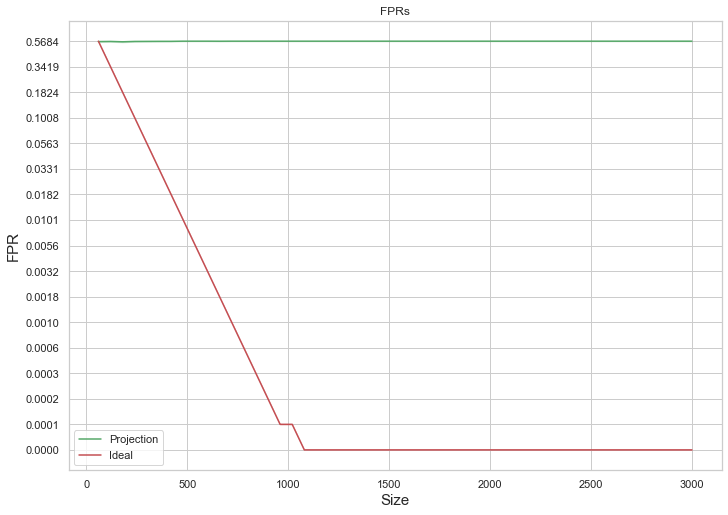

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [27]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

1000


In [28]:
average_times = num_of_iterations*average_times
print(len(average_times))

1000


In [29]:
print(average_fprs)

['0.016000', '0.010000', '0.024000', '0.010000', '0.008000', '0.006000', '0.006000', '0.000000', '0.000000', '0.000000', '0.002000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.016000', '0.010000', '0.024000', '0.010000', '0.008000', '0.006000', '0.006000', '0.000000', '0.000000', '0.000000', '0.002000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.

In [47]:
print(average_fprs)

[0.008, 0.0, 0.018, 0.019999999999999997, 0.008, 0.018, 0.014000000000000002, 0.012, 0.019999999999999997, 0.008, 0.018, 0.018, 0.01, 0.016, 0.006, 0.01, 0.023999999999999997, 0.008, 0.022, 0.012, 0.016, 0.012, 0.014000000000000002, 0.012, 0.014000000000000002, 0.014000000000000002, 0.004, 0.012, 0.008, 0.019999999999999997, 0.006, 0.013999999999999999, 0.014000000000000002, 0.02, 0.006, 0.004, 0.01, 0.004, 0.004, 0.006, 0.008, 0.002, 0.002, 0.0, 0.0, 0.004, 0.002, 0.002, 0.004, 0.01, 0.004, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.002, 0.004, 0.004, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [21]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,0.9948,0.000602,0.000531,0.0,0.000000,0.069621,0.057264
1,20,0.9231,0.000365,0.000354,0.0,0.000000,0.034374,0.078431
2,30,0.8164,0.000405,0.000447,0.0,0.000000,0.037457,0.043448
3,40,0.7180,0.000572,0.000415,0.0,0.000000,0.036150,0.041078
4,50,0.6358,0.000341,0.000325,0.0,0.000000,0.060021,0.057534


In [22]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Iris_rerun_epochs_100.csv')